In [8]:
import numpy as np
import scipy
from scipy.special import erfc
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise, Lambda
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
import keras.backend as K
import matplotlib.pyplot as plt

In [9]:
# Encoder Parameters
k = 2
M = 2**k
n = 1
#R = k/n
R = 2
beta = 0.01

# Channel Parameters
EbNo = 10.0**(5/10.0)
noise_std = np.sqrt(1/(2*EbNo))

In [10]:
# generating training data of size N
N = 32000
label = np.random.randint(M,size=N)

#creating one-hot encoded vector
train_data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    train_data.append(temp)
train_data = np.array(train_data)

In [11]:
# generating validation data of size N_val
N_val = 15000
val_label = np.random.randint(M,size=N_val)

#creating one-hot encoded vector
val_data = []
for i in val_label:
    temp = np.zeros(M)
    temp[i] = 1
    val_data.append(temp)
val_data = np.array(val_data)

In [12]:
# generating test data of size N_test
N_test = 50000
test_label = np.random.randint(M,size=N_test)

#creating one-hot encoded vector
test_data = []
for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
test_data = np.array(test_data)

In [13]:
def rotate(x):
    return K.concatenate([x, x*0], axis=1)
    #return K.concatenate([x*np.cos(np.pi/4), x*np.sin(np.pi/4)], axis=1)

def rotate_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2  # only valid for 2D tensors
    shape[-1] *= 2
    return tuple(shape)

In [14]:
def nonlin_Gaussian(x,noise_std1):
    noise = np.zeros(x.shape) 
    for i in range(len(x)):
        nois = np.random.randn(1,2) # complex Gaussian RV
        var = 0
        absol = np.sqrt(np.sum(np.square(x[i])))
        var = beta*np.square(absol)+np.square(noise_std1)
        noi = np.sqrt(var)*nois
        noise[i] = (noi)
    return noise 

In [15]:
# Defining Autoencoder

# Transmitter Layers 
input_signal = Input(shape=[M,])
encoded = Dense(M, activation='relu')(input_signal)
encoded = Dense(n, activation='linear')(encoded)

# Normalization Layer (Fixed Energy Constraint)
#encoded = Lambda(lambda x: K.l2_normalize(x,axis=-1)*np.sqrt(n))(encoded) 

# Normalization Layer (Average Power Normalization)
encoded = Lambda(lambda x: x / K.sqrt(K.mean(x**2)))(encoded)

# Arbitary Normalization
encoded = Lambda(rotate, output_shape=rotate_output_shape)(encoded)

# Non Linear Gaussian Channel Layer
var = Lambda(lambda x: beta*K.square(K.sqrt(K.sum(K.square(x),axis = 1, keepdims = True)))+K.square(tf.cast(noise_std, tf.float32)))(encoded)
noised  = Lambda(lambda x: x + K.sqrt(var)*K.random_normal(shape=K.shape(x), mean=0., stddev=1.))(encoded)

# Receiver Layers
decoded = Dense(M, activation='relu')(noised)
decoded = Dense(M, activation='softmax')(decoded)

autoencoder = Model(input_signal, decoded)
print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 2)                 0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12  

In [16]:
adam = Adam(lr=0.01)
autoencoder.compile(optimizer = adam, loss = 'categorical_crossentropy')
hist = autoencoder.fit(train_data, train_data,
                epochs = 200, 
                batch_size = 1024, 
                validation_data = (val_data,val_data)
               )

Train on 32000 samples, validate on 15000 samples
Epoch 1/200
32000/32000 [==============================] - 0s 12us/step - loss: 1.3096 - val_loss: 1.1014
Epoch 2/200
32000/32000 [==============================] - 0s 4us/step - loss: 0.9182 - val_loss: 0.7627
Epoch 3/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.6912 - val_loss: 0.6304
Epoch 4/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.5949 - val_loss: 0.5621
Epoch 5/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.5376 - val_loss: 0.5184
Epoch 6/200
32000/32000 [==============================] - 0s 4us/step - loss: 0.5070 - val_loss: 0.4909
Epoch 7/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4808 - val_loss: 0.4812
Epoch 8/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4768 - val_loss: 0.4764
Epoch 9/200
32000/32000 [==============================] - 0s 4us/step - loss: 0.4648 - val_loss: 0.4580
Epoc

Epoch 78/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4658 - val_loss: 0.4707
Epoch 79/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4644 - val_loss: 0.4698
Epoch 80/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4681 - val_loss: 0.4714
Epoch 81/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4632 - val_loss: 0.4696
Epoch 82/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4670 - val_loss: 0.4632
Epoch 83/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4641 - val_loss: 0.4738
Epoch 84/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4669 - val_loss: 0.4707
Epoch 85/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4733 - val_loss: 0.4747
Epoch 86/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4669 - val_loss: 0.4699
Epoch 87/200
32000/32000 [====================

32000/32000 [==============================] - 0s 3us/step - loss: 0.4634 - val_loss: 0.4694
Epoch 155/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4627 - val_loss: 0.4706
Epoch 156/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4671 - val_loss: 0.4694
Epoch 157/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4720 - val_loss: 0.4609
Epoch 158/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4696 - val_loss: 0.4645
Epoch 159/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4618 - val_loss: 0.4637
Epoch 160/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4676 - val_loss: 0.4658
Epoch 161/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4679 - val_loss: 0.4664
Epoch 162/200
32000/32000 [==============================] - 0s 3us/step - loss: 0.4650 - val_loss: 0.4603
Epoch 163/200
32000/32000 [========================

In [17]:
decoded_data = autoencoder.predict(test_data)

In [18]:
# encoder from full autoencoder
encoder = Model(input_signal, encoded)

# channel from full autoencoder
channel_input = Input(shape = [n,])
channel = autoencoder.layers[-3](channel_input)
channel_layer = Model(channel_input, channel)
channel1 = Model(input_signal,noised)

# decoder from full autoencoder
encoded_input = Input(shape = [2*n,])

decoder = autoencoder.layers[-2](encoded_input)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

In [19]:
# plotting learned constellation diagram
identity_matrix = np.eye(M)
np.random.shuffle(identity_matrix)
constellation = encoder.predict(identity_matrix) 

In [20]:
constellation 

array([[ 1.3762609 ,  0.        ],
       [-1.3635696 , -0.        ],
       [-0.34956577, -0.        ],
       [ 0.35268587,  0.        ]], dtype=float32)

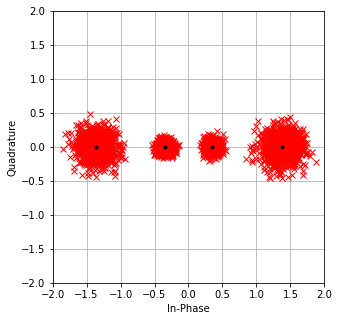

In [21]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, aspect='equal')

N = 1000
EbNo1 = 10.0**(20/10.0)
noise_std1 = np.sqrt(1/(2*R*EbNo1))
for i in range(len(constellation)):
    absol = np.sqrt(np.sum(np.square(constellation[i])))
    var = beta*np.square(absol)+np.square(noise_std1)
    w = np.random.randn(N,2)*np.sqrt(var);
    plt.plot(constellation[i,0]+w[:,0],constellation[i,1]+w[:,1],'rx')

plt.plot(constellation[:,0], constellation[:,1], 'k.')
plt.grid(True)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
#plt.title('Learned Constellation (%d) (NonLin Gaussian)' %M)
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
#plt.savefig('4AEC.eps',format='eps')
plt.show()

In [22]:
# calculating BER (Autoencoder)
EbNodB_range = list(np.arange(-2,12.5,0.5))
ber = [None]*len(EbNodB_range)
for i in range(0, len(EbNodB_range)):
    EbNo = 10.0**(EbNodB_range[i]/10.0)
    noise_std = np.sqrt(1/(2*EbNo))
    no_err = 0


    encoded_signal = encoder.predict(test_data)
    noise = nonlin_Gaussian(encoded_signal,noise_std)
    noise_signal = encoded_signal + noise
    final_signal = decoder.predict(noise_signal)
    pred_out = np.argmax(final_signal, axis = 1)
    
    no_err = (pred_out != test_label)
    no_err = no_err.astype(int).sum()
    ber[i] = no_err / (N_test*k)
    print('EbNo:',EbNodB_range[i], 'BER:',ber[i])
    

EbNo: -2.0 BER: 0.23085
EbNo: -1.5 BER: 0.22214
EbNo: -1.0 BER: 0.21511
EbNo: -0.5 BER: 0.20582
EbNo: 0.0 BER: 0.19859
EbNo: 0.5 BER: 0.18752
EbNo: 1.0 BER: 0.17881
EbNo: 1.5 BER: 0.17155
EbNo: 2.0 BER: 0.16129
EbNo: 2.5 BER: 0.15252
EbNo: 3.0 BER: 0.14254
EbNo: 3.5 BER: 0.13223
EbNo: 4.0 BER: 0.12228
EbNo: 4.5 BER: 0.11288
EbNo: 5.0 BER: 0.10201
EbNo: 5.5 BER: 0.09356
EbNo: 6.0 BER: 0.08433
EbNo: 6.5 BER: 0.07589
EbNo: 7.0 BER: 0.06729
EbNo: 7.5 BER: 0.0596
EbNo: 8.0 BER: 0.0512
EbNo: 8.5 BER: 0.04466
EbNo: 9.0 BER: 0.0379
EbNo: 9.5 BER: 0.03164
EbNo: 10.0 BER: 0.02708
EbNo: 10.5 BER: 0.02145
EbNo: 11.0 BER: 0.01865
EbNo: 11.5 BER: 0.01511
EbNo: 12.0 BER: 0.0127


In [23]:
# 4 PAM BER (Nonlin Gaussian)
ber_c = [None]*len(EbNodB_range)

alphaMqam = np.array([-3, -1, 1, 3])
ipHat = np.zeros([1,N_test])

for i in range(0, len(EbNodB_range)):
    ip = np.random.choice(alphaMqam, N_test)
    
    s = np.zeros([N_test,2])
    for j in range(len(ip)):
        s[j][0] = ip[j]
        s[j][1] = 0
    s = s * (1/np.sqrt(5))
    no_err = 0
    
    EbNo = 10.0**(EbNodB_range[i]/10.0)
    noise_std = np.sqrt(1/(2*k*EbNo))
    noise = nonlin_Gaussian(s,noise_std)
    #noise = noise_std * np.random.randn(N_test,n)
    y = s + noise
    y = y.view(np.complex128).flatten()
    
    y_re = y.real
    
    ipHat_re = np.zeros(y_re.shape)
    
    ipHat_re[np.where(y_re < -2/np.sqrt(5))]           = -3
    ipHat_re[np.where(y_re > 2/np.sqrt(5))]            =  3
    ipHat_re[np.where((y_re>-2/np.sqrt(5)) & (y_re<=0))]  = -1
    ipHat_re[np.where((y_re>0) & (y_re<=2/np.sqrt(5)))]   =  1

    ipHat = ipHat_re 
    
    no_err = (ipHat != ip) 
    no_err = no_err.astype(int).sum()
    ber_c[i] = no_err / (N_test*k)
    print('EbNo:',EbNodB_range[i], 'BER:',ber_c[i])

EbNo: -2.0 BER: 0.18065
EbNo: -1.5 BER: 0.16987
EbNo: -1.0 BER: 0.1621
EbNo: -0.5 BER: 0.15166
EbNo: 0.0 BER: 0.14074
EbNo: 0.5 BER: 0.13228
EbNo: 1.0 BER: 0.12275
EbNo: 1.5 BER: 0.11175
EbNo: 2.0 BER: 0.10083
EbNo: 2.5 BER: 0.09151
EbNo: 3.0 BER: 0.08307
EbNo: 3.5 BER: 0.07258
EbNo: 4.0 BER: 0.06482
EbNo: 4.5 BER: 0.0566
EbNo: 5.0 BER: 0.04781
EbNo: 5.5 BER: 0.04003
EbNo: 6.0 BER: 0.03333
EbNo: 6.5 BER: 0.02871
EbNo: 7.0 BER: 0.02295
EbNo: 7.5 BER: 0.0186
EbNo: 8.0 BER: 0.01497
EbNo: 8.5 BER: 0.01152
EbNo: 9.0 BER: 0.00881
EbNo: 9.5 BER: 0.00724
EbNo: 10.0 BER: 0.00566
EbNo: 10.5 BER: 0.00434
EbNo: 11.0 BER: 0.00341
EbNo: 11.5 BER: 0.00242
EbNo: 12.0 BER: 0.00206


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


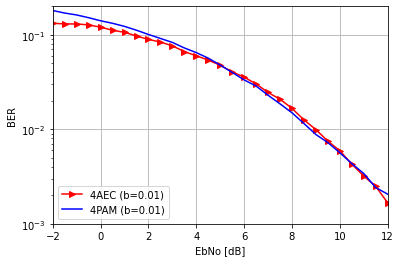

In [28]:
fig, ax = plt.subplots()
ax.plot(EbNodB_range,ber, 'r->', label = '%dAEC (b=0.01)' %M)
ax.plot(EbNodB_range,ber_c, 'b-', label = '%dPAM (b=0.01)' %M)
#plt.title('%dPAM Non-Linear' %M)
plt.yscale('log')
plt.ylim([1e-03,0.2])
plt.xlim([-2,12])
plt.xlabel('EbNo [dB]')
plt.ylabel('BER')
plt.grid()
legend = ax.legend(loc = 'lower left', ncol = 1)
#plt.savefig('4AECnon001.eps', format='eps')
plt.show()

In [25]:
ber = [0.18929*0.7,0.17385*0.75,0.16283*0.8,0.15336*0.83,0.14336*0.84,0.13144*0.85,
       0.12342*0.86,0.11157*0.87,0.10152*0.88,0.09425*0.89,0.08485*0.9,0.07383*0.9,
       0.06515*0.92,0.05808*0.93,0.05064*0.94,0.04266*0.95,0.03565,0.03028,
       0.02452,0.02082,0.01666,0.0126,0.00993,0.0075,
       0.00594,0.00429,0.0032,0.002497,0.00167]